In [1]:
# torch family
import torch
from torch.utils.data import DataLoader, Subset

# torchvision family
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import datasets, transforms
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torchvision.ops import nms

# utils
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import utils
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import json

In [2]:
data_dir = '../../../dataset/COCO2017'
img_dir = os.path.join(data_dir, 'val2017')
ann_file = os.path.join(data_dir, 'annotations/instances_val2017.json')

In [3]:
class CustomCocoDetection(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, transform=None):
        self.root = img_dir
        self.transform = transform
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(os.path.join(self.root, path)).convert('RGB')

        boxes = []
        labels = []
        areas = []
        iscrowd = []
        image_id = torch.tensor([img_id])
    
        for ann in anns:
            bbox = np.array(ann['bbox'])
            bbox[2:4] = bbox[0:2] + bbox[2:4]
            boxes.append(bbox)
            labels.append(ann['category_id'])
            areas.append(ann['area'])
            iscrowd.append(ann['iscrowd'])

        boxes = np.array(boxes)

        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            areas = torch.as_tensor(areas, dtype=torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            areas = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)
            
        if self.transform is not None:
            img, boxes = self.transform(img, boxes)
            
        target = {'boxes': boxes,
                  'labels': labels,
                 'image_id': image_id,
                 'area': areas,
                 'iscrowd': iscrowd
                 }
    
        return img, target

    def __len__(self):
        return len(self.ids)

class ResizeTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, image, boxes):
        w, h = image.size
        image = F.resize(image, self.size)
        new_w, new_h = self.size

        scale_w = new_w / w
        scale_h = new_h / h

        boxes[:, [0, 2]] *= scale_w
        boxes[:, [1, 3]] *= scale_h

        return image, boxes

class ToTensorTransform:
    def __call__(self, image, boxes):
        image = F.to_tensor(image)
        return image, boxes

class ComposeTransform:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, boxes):
        for t in self.transforms:
            image, boxes = t(image, boxes)
        return image, boxes

In [4]:
#transform = ComposeTransform([ResizeTransform((320, 320)), ToTensorTransform()])
transform = ComposeTransform([ToTensorTransform()])

In [5]:
valid_dataset = CustomCocoDetection(img_dir, ann_file, transform=transform)

"""
subset_size = len(valid_dataset) // 10
indices = np.random.choice(len(valid_dataset), subset_size, replace=False)
valid_subset = Subset(valid_dataset, indices)
"""

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


'\nsubset_size = len(valid_dataset) // 10\nindices = np.random.choice(len(valid_dataset), subset_size, replace=False)\nvalid_subset = Subset(valid_dataset, indices)\n'

In [7]:
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=utils.collate_fn)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(weights='COCO_V1',
                                num_classes = 91)

model = model.to(device)

In [9]:
def evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []

    score_threshold = 0.5
    nms_threshold = 0.5
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)
            for i, output in enumerate(outputs):
                image_id = targets[i]["image_id"].item()
                boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                labels = output["labels"].cpu().numpy()

                boxes[:, 2:] -= boxes[:, :2]  # Convert to [x, y, w, h]
     
                high_score_idxs = scores > score_threshold
                filtered_boxes = boxes[high_score_idxs]
                filtered_scores = scores[high_score_idxs]
                filtered_labels = labels[high_score_idxs]
                
                if len(high_score_idxs) == 0:
                    continue
                
                keep = nms(torch.from_numpy(filtered_boxes),
                           torch.from_numpy(filtered_scores),
                           nms_threshold)

                nms_boxes = filtered_boxes[keep]
                nms_scores = filtered_scores[keep]
                nms_labels = filtered_labels[keep]

                if len(keep) == 0:
                    continue

                if len(keep) == 1:
                    nms_boxes = np.expand_dims(nms_boxes, axis=0)
                    nms_scores = np.expand_dims(nms_scores, axis=0)
                    nms_labels = np.expand_dims(nms_labels, axis=0)

                for box, score, label in zip(nms_boxes, nms_scores, nms_labels):
                    result = {
                        "image_id": int(image_id),
                        "category_id": int(label),
                        "bbox": box.tolist(),
                        "score": float(score),
                    }
                    results.append(result)
                image_ids.append(image_id)

    return results, image_ids

In [10]:
def coco_evaluation(ann_file, results):
    coco_gt = COCO(ann_file)
    coco_dt = coco_gt.loadRes(results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

In [11]:
ann_file_valid = ann_file

In [12]:
results, image_ids = evaluate(model, valid_loader, device)

with open('result.json', 'w') as f:
    json.dump(results, f)

print("DONE!")

/home/hwkang/jupyter/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


DONE!


In [13]:
coco_evaluation(ann_file_valid, 'result.json')

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.30s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=9.36s).
Accumulating evaluation results...
DONE (t=1.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.376
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.279
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [15]:
def draw_boxes(image, boxes, color):
    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(box, outline=color, width=3)

def show_image_with_boxes(image, pred_boxes, true_boxes, green=True, red=True):
    image = T.ToPILImage()(image).convert("RGB")
    
    if red:
        draw_boxes(image, pred_boxes, color='red')
    if green:
        draw_boxes(image, true_boxes, color='green')

    plt.imshow(image)
    plt.show()

In [22]:
def get_result_as_json(image_id, pred_boxes, pred_scores, pred_labels, s_thrs=0.5, n_thrs=0.5):
    # Convert XYXY to XYWH
    pred_boxes[2:4] -= pred_boxes[0:2]

    # Score filtering
    high_score_idxs = pred_scores > s_thrs
    filtered_boxes = pred_boxes[high_score_idxs]
    filtered_scores = pred_scores[high_score_idxs]
    filtered_labels = pred_labels[high_score_idxs]

    # NMS filtering
    keep_idxs = nms(torch.from_numpy(filtered_boxes), torch.from_numpy(filtered_scores), n_thrs)
    nms_boxes = filtered_boxes[keep_idxs]
    nms_scores = filtered_scores[keep_idxs]
    nms_labels = filtered_labels[keep_idxs]

    if len(keep_idxs) == 1:
        nms_boxes = np.expand_dims(nms_boxes, axis=0)
        nms_scores = np.expand_dims(nms_scores, axis=0)
        nms_labels = np.expand_dims(nms_labels, axis=0)

    results = []

    for bbox, score, label in zip(nms_boxes, nms_scores, nms_labels):
        result = {
            'image_id': int(image_id),
            'category_id': int(label),
            'bbox': bbox.tolist(),
            'score': float(score)
        }
        results.append(result)

    return results

In [23]:
# 모델을 평가 모드로 전환
model.eval()

# 이미지와 예측 결과 가져오기
images, targets = next(iter(valid_loader))
images = list(img.to(device) for img in images)
outputs = model(images)

# 첫 번째 이미지에 대해 예측과 실제 bbox 비교
image = images[0].cpu()

#true_boxes = targets[0]['boxes'].cpu().numpy()
image_id = targets[0]['image_id']
pred_boxes = outputs[0]['boxes'].cpu().detach().numpy()
pred_scores = outputs[0]['scores'].cpu().detach().numpy()
pred_labels = outputs[0]['labels'].cpu().detach().numpy()

In [24]:
result_json = get_result_as_json(image_id, pred_boxes, pred_scores, pred_labels)

In [ ]:
for record in result_json:
    print(record)

In [ ]:
#show_image_with_boxes(image, nms_boxes, true_boxes, green=True, red=True)

In [ ]:
coco = COCO(ann_file)

image_id = image_id.item()

ann_ids = coco.getAnnIds(imgIds=image_id)

anns = coco.loadAnns(ann_ids)

[28]:[1.08, 4.31, 469.21, 470.3]
[1]:[466.16, 442.44, 82.9, 37.45]


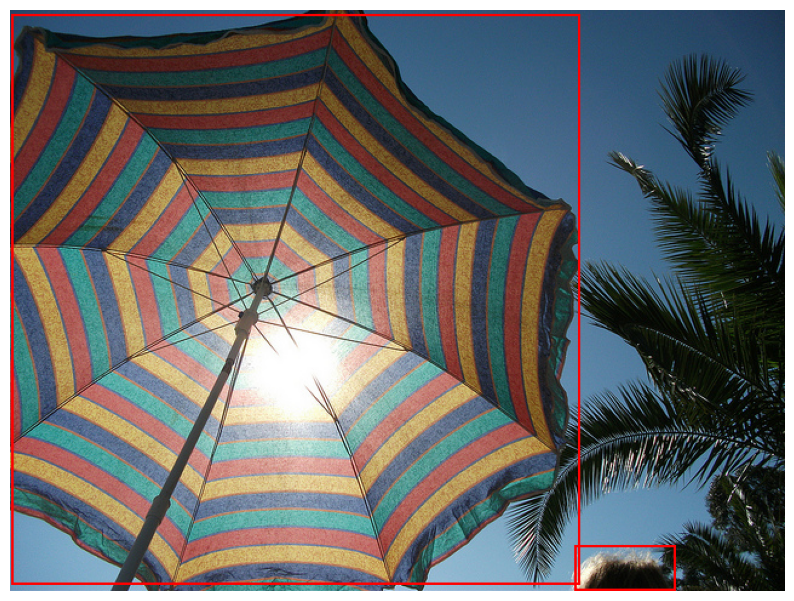

In [24]:
# 이미지 정보 로드
img_info = coco.loadImgs(image_id)[0]
img_path = f"{img_dir}/{img_info['file_name']}"

# 이미지 로드
image_ = Image.open(img_path).convert('RGB')
draw = ImageDraw.Draw(image_)
for ann in anns:
    bbox = ann['bbox']
    label = ann['category_id']
    print(f'[{label}]:{bbox}')
    # COCO 형식의 bbox는 [x_min, y_min, width, height]
    x_min, y_min, width, height = bbox
    x_max = x_min + width
    y_max = y_min + height
    draw.rectangle([x_min, y_min, x_max, y_max], outline='red', width=2)

# 이미지 출력
plt.figure(figsize=(10, 10))
plt.imshow(image_)
plt.axis('off')
plt.show()

### (참고)
### 인덱스 정렬이 안돼서 라벨 예측을 틀리게 한 것일 수 있음
### 또는 Subset을 사용해서 검증 데이터의 일부(1/10)만으로 테스트를 수행해서 그런 것일 수 있음 -> 이 문제였던 것으로 밝혀짐